In [1]:
# !pip unin numpy

In [1]:
import torch
import numpy as np
import pandas as pd
import os
import sys

In [2]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

In [3]:
from torch.utils.data import TensorDataset, DataLoader

In [4]:
import torch.nn as nn
from torch import optim

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
# !pip install shap

In [8]:
import shap

## General split

In [15]:
data = pd.read_csv('../data/gesture-recognition-and-biometrics-electromyogram-grabmyo-1.0.2/features_v2.csv')

In [16]:
data.head()

,session,trial,filename,crest_factor_F1,dasd_F1,diffvar_F1,form_factor_F1,iemg_F1,kurtosis_F1,kurtosis_f_F1,...,rms_W9,skew_W9,skew_f_W9,ssi_W9,sum_f_W9,var_f_W9,wflen_W9,willison_W9,gesture,participant
0,1,1,E:\DS5500-project\data\gesture-recognition-and...,7.091099,0.021834,0.000606,-6502.754507,365.456658,2.574033,85.547962,...,0.022588,-0.148877,5.529415,5.224663,0.109574,2.901826e-10,69.944068,15.0,10,1
1,1,2,E:\DS5500-project\data\gesture-recognition-and...,13.324514,0.023852,0.000689,1352.897349,379.664639,16.942218,329.114870,...,0.016172,-0.205427,9.332349,2.677940,0.077566,2.769772e-10,54.530919,23.0,10,1
2,1,3,E:\DS5500-project\data\gesture-recognition-and...,8.047954,0.016213,0.000326,1295.052394,296.823135,3.795827,134.751765,...,0.017039,-0.204604,9.078430,2.973002,0.064458,1.426359e-10,57.815909,13.0,10,1
3,1,4,E:\DS5500-project\data\gesture-recognition-and...,8.459555,0.026572,0.000864,14453.068135,479.688214,6.938354,98.832790,...,0.031982,-0.266818,5.067522,10.473811,0.131909,4.509337e-10,83.441138,0.0,10,1
4,1,5,E:\DS5500-project\data\gesture-recognition-and...,8.329011,0.026896,0.000901,11827.310277,464.350257,2.379207,116.412205,...,0.031134,-0.092205,5.414199,9.925787,0.177516,9.577100e-10,94.393506,3.0,10,1


In [17]:
data.columns

Index(['session', 'trial', 'filename', 'crest_factor_F1', 'dasd_F1',
       'diffvar_F1', 'form_factor_F1', 'iemg_F1', 'kurtosis_F1',
       'kurtosis_f_F1',
       ...
       'rms_W9', 'skew_W9', 'skew_f_W9', 'ssi_W9', 'sum_f_W9', 'var_f_W9',
       'wflen_W9', 'willison_W9', 'gesture', 'participant'],
      dtype='object', length=761)

In [18]:
feature_cols = [c for c in data.columns if "_" in c]

In [19]:
feature_names = feature_cols

In [20]:
X = data.loc[:, feature_cols].values
Y = (data.loc[:, 'gesture']-1).values

In [21]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [22]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=56)

In [23]:
# scaler = StandardScaler()
# # scaler.fit(x_train)
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.transform(x_test)

In [24]:
def simple_model(input_shape, output_shape):
    model = nn.Sequential(
        nn.Linear(input_shape, 64),  # Input layer: Fully connected (linear) with 64 units
        nn.ReLU(),  # Activation function: ReLU,
        nn.Dropout(0.3),
        nn.Linear(64, 256),
        nn.ReLU(),  # Activation function: ReLU
        nn.Dropout(0.3),
        nn.Linear(256, 128),
        nn.ReLU(),  # Activation function: ReLU
        nn.Dropout(0.3),
        nn.Linear(128, output_shape)  # Output layer: Fully connected (linear) with 'output_shape' units
    )
    
    return model

In [25]:
train_dataset = TensorDataset(torch.tensor(x_train).type(torch.float32), torch.tensor(y_train).type(torch.LongTensor))
test_dataset = TensorDataset(torch.tensor(x_test).type(torch.float32), torch.tensor(y_test).type(torch.LongTensor))

In [26]:
len(np.unique(y_train))

17

In [27]:
# Define batch size and whether to shuffle the data
batch_size = 256
shuffle = True

# Create data loaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [28]:
len(train_dataset)

12280

In [29]:
x_train.shape

(12280, 756)

In [30]:
model = simple_model(x_train.shape[1], len(np.unique(y_train)))

In [31]:
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=5e-4)

In [32]:
# Define training parameters
num_epochs = 100

In [33]:
# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_train_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # Validation phase
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_loader):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate and log metrics
    train_loss = total_train_loss / len(train_loader)
    val_loss = total_val_loss / len(test_loader)
    val_accuracy = 100 * correct / total

    if (epoch+1)%20==0:
        print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

Epoch [20/100] - Train Loss: 0.5715, Val Loss: 0.5343, Val Accuracy: 84.83%
Epoch [40/100] - Train Loss: 0.3974, Val Loss: 0.5158, Val Accuracy: 88.08%
Epoch [60/100] - Train Loss: 0.3364, Val Loss: 0.4905, Val Accuracy: 89.51%
Epoch [80/100] - Train Loss: 0.2793, Val Loss: 0.4915, Val Accuracy: 89.61%
Epoch [100/100] - Train Loss: 0.2451, Val Loss: 0.4568, Val Accuracy: 90.95%


In [39]:
def predict(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    y_pred = []

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_loader):
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.tolist())

    return y_pred

In [42]:
def predict_one(model, test_loader, label):
    model.eval()  # Set the model to evaluation mode
    y_pred = []

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_loader):
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            # if labels == label:
            y_pred.extend(predicted.tolist())

    return y_pred

In [43]:
y_test_pred = predict(model, test_loader)

In [60]:
from collections import Counter

In [62]:
def get_most_pred(y_test_pred, y_test, label):
    return Counter(np.take(y_test_pred, np.where(y_test == label)[0]))
    

In [81]:
get_most_pred(y_test_pred, y_test, 3)

Counter({3: 143,
         6: 16,
         1: 8,
         14: 6,
         16: 3,
         2: 3,
         7: 2,
         4: 1,
         8: 1,
         13: 1,
         10: 1,
         0: 1})

In [83]:
8/186

0.043010752688172046

In [36]:
report = classification_report(y_test, y_test_pred, target_names=MotionName)
print(report)

                                    precision    recall  f1-score   support

                Lateral Prehension       0.85      0.80      0.83       186
                   Thumb Adduction       0.84      0.84      0.84       179
Thumb and Little Finger Opposition       0.83      0.92      0.87       181
 Thumb and Index Finger Opposition       0.92      0.77      0.84       186
  Thumb and Index Finger Extension       0.96      0.91      0.94       198
 Thumb and Little Finger Extension       0.98      0.95      0.97       202
 Index and Middle Finger Extension       0.79      0.88      0.83       182
           Little Finger Extension       0.93      0.92      0.92       179
            Index Finger Extension       0.89      0.88      0.88       175
            Thumb Finger Extension       0.92      0.94      0.93       165
                   Wrist Extension       0.98      1.00      0.99       176
                     Wrist Flexion       0.99      0.96      0.98       167
           

In [37]:
MotionName = [ 'Lateral Prehension'  , 'Thumb Adduction'  , 'Thumb and Little Finger Opposition'  ,  
     'Thumb and Index Finger Opposition'  , 'Thumb and Index Finger Extension'  , 'Thumb and Little Finger Extension'  ,  
     'Index and Middle Finger Extension'  , 'Little Finger Extension'  , 'Index Finger Extension'  ,  
     'Thumb Finger Extension'  , 'Wrist Extension'  , 'Wrist Flexion'  ,  
     'Forearm Supination'  , 'Forearm Pronation'  , 'Hand Open'  ,  
     'Hand Close'  ,  'Rest'  ]

In [80]:
MotionName[6]

'Index and Middle Finger Extension'

In [250]:
precision_micro = precision_score(y_test, y_test_pred, average = "micro")

In [251]:
np.mean(x_train, axis = 0)[:10]

array([-3.40559665e-04,  2.84161866e-03,  1.29559590e-03, -8.07134312e-03,
        1.91266310e-03, -1.08276272e-03, -2.37718230e-03,  1.91266310e-03,
        2.06587919e-03, -7.42489821e-05])

In [252]:
np.mean(x_test, axis = 0)[:10]

array([ 0.0013618 , -0.01136277, -0.0051807 ,  0.03227486, -0.00764816,
        0.00432964,  0.00950563, -0.00764816, -0.00826083,  0.0002969 ])

In [253]:
test_data = next(iter(test_loader))

In [254]:
background_data = test_data[0][:80]

In [255]:
test = test_data[0][80:]

In [256]:
e = shap.DeepExplainer(model, background_data)

In [257]:
shap_values = e.shap_values(test)

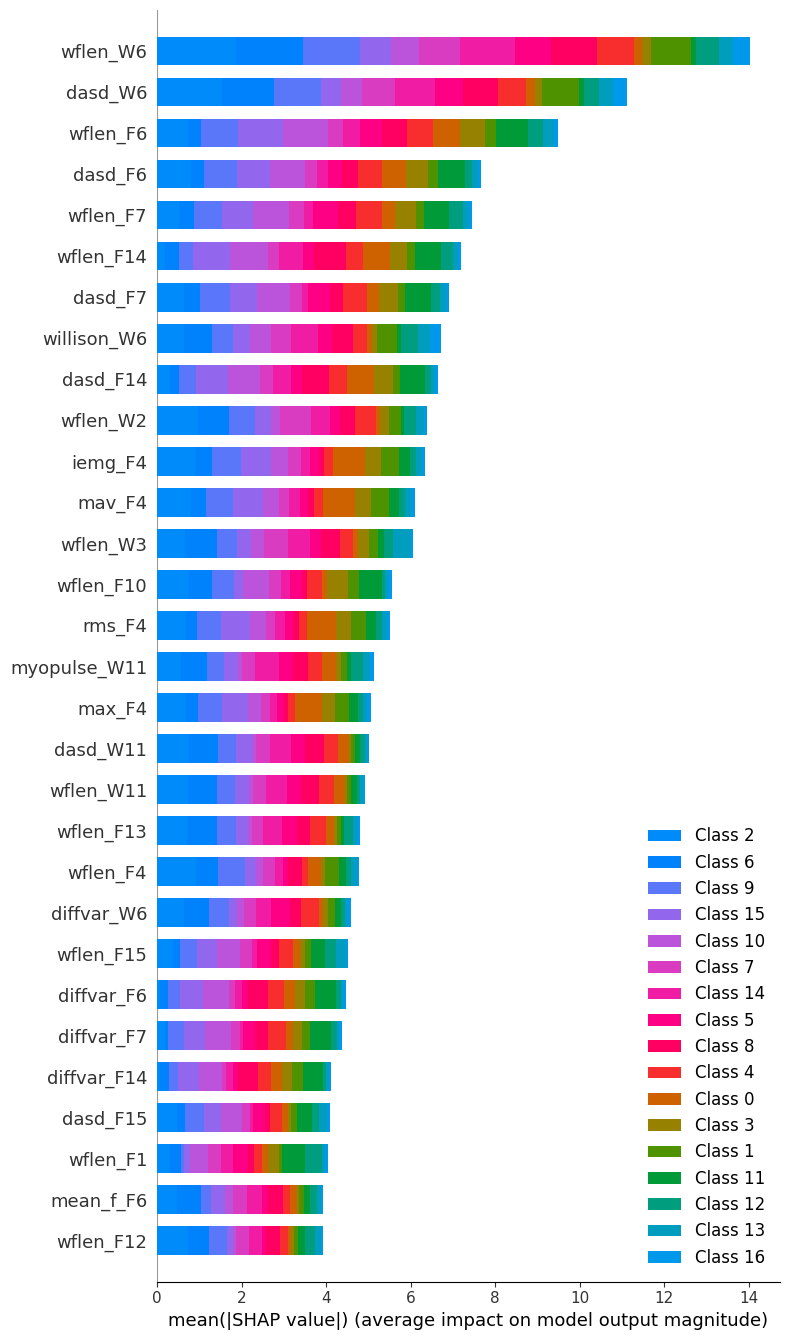

In [258]:
shap.summary_plot(shap_values, feature_names=feature_names, max_display=30)

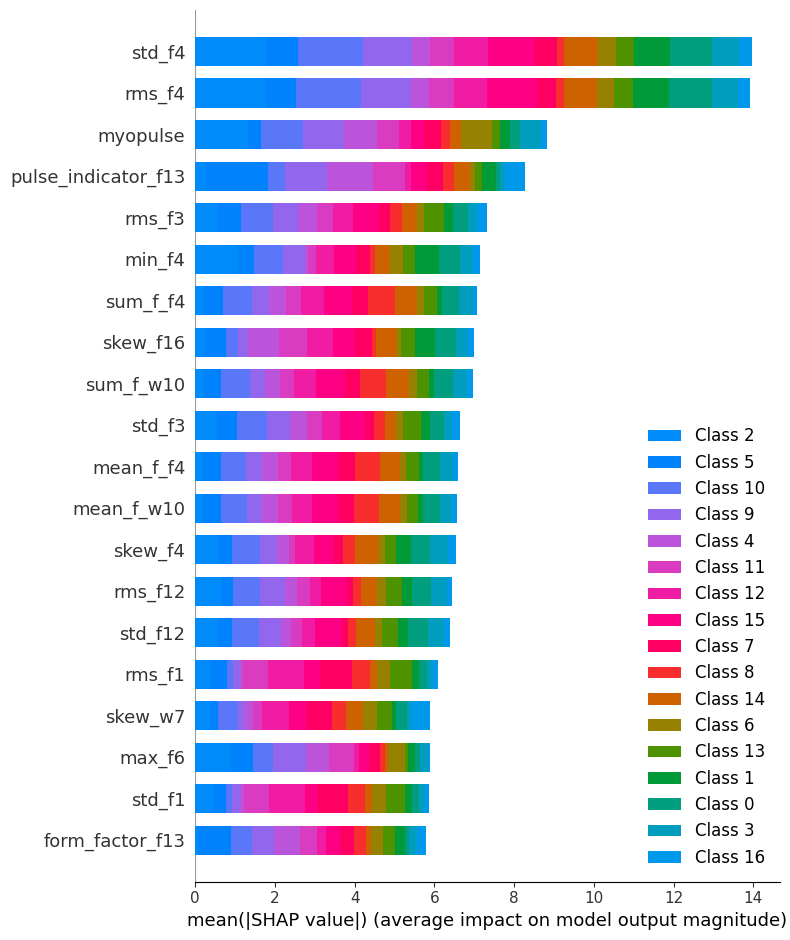

In [141]:
shap.summary_plot(shap_values, feature_names=feature_names)

In [44]:
test_parts

[39, 40, 41, 42, 43]

## Split on participants

In [12]:
participants = list(range(5,43))
test_participants = list(range(1,5))

In [13]:
train_df = data[data['participant'].isin(participants)]
test_df = data[data['participant'].isin(test_participants)]

In [14]:
train_df

,session,participant,gesture,index,iemg,mav,ssi,myopulse,wflen,diffvar,...,kurtosis_f_w3,kurtosis_f_w4,kurtosis_f_w5,kurtosis_f_w6,kurtosis_f_w7,kurtosis_f_w8,kurtosis_f_w9,kurtosis_f_w10,kurtosis_f_w11,kurtosis_f_w12
119,1,10,10,0,6797.436339,0.023708,313.982240,7.401855,5733.301325,0.000904,...,79.115045,32.591676,58.994440,54.839028,50.292229,104.307591,61.155945,196.373417,92.713179,405.962532
120,1,10,10,0,14079.062764,0.049104,1291.830907,6.844043,10385.642760,0.002613,...,12.381097,12.099599,10.995862,17.486544,14.211067,14.489695,16.576432,160.712336,79.746286,170.230168
121,1,10,10,0,11472.717905,0.040014,960.778273,6.713477,8706.221451,0.002182,...,48.730862,305.459894,212.763290,36.980016,29.056499,299.450092,55.901194,64.921149,59.408569,167.539726
122,1,10,10,0,17507.830172,0.061062,2332.784349,6.788477,13368.566593,0.005666,...,51.993926,51.528948,20.339587,43.117535,34.757809,59.816264,20.777295,59.169183,45.939629,43.873509
123,1,10,10,0,18614.528512,0.064922,2580.763916,6.342676,13226.563635,0.005325,...,306.354173,55.281935,15.773219,26.464685,84.562723,76.696436,19.323875,37.940924,24.052192,41.660051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15346,3,9,9,0,7435.557234,0.025933,369.818221,6.280762,5792.222983,0.001070,...,29.589425,25.460694,182.962449,34.957161,18.846525,37.714119,26.569683,32.614845,12.793219,16.657922
15347,3,9,9,0,10471.625678,0.036522,713.052200,6.967187,8628.380136,0.002070,...,18.226247,35.715660,113.822913,64.223311,8.214120,39.211218,29.910432,26.426457,24.892159,82.241098
15348,3,9,9,0,11279.138159,0.039339,815.440185,6.917773,9229.795138,0.002355,...,15.486525,29.417342,25.153035,19.632020,15.590478,15.462391,34.940941,37.564280,14.208021,15.811267
15349,3,9,9,0,9210.946156,0.032125,563.422838,7.359570,8040.357766,0.001839,...,14.527208,20.281059,20.418717,18.471741,14.276295,10.083487,27.337412,12.804675,20.220452,37.494222


In [15]:
x_train = train_df.iloc[:, 4:].values
y_train = (train_df.iloc[:, 2] - 1).values

x_test = test_df.iloc[:, 4:].values
y_test = (test_df.iloc[:, 2] - 1).values


In [16]:
scaler = StandardScaler()

In [17]:
scaler.fit(x_train)

StandardScaler()

In [18]:
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [19]:
x_train

array([[-0.71151404, -0.71151404, -0.44104706, ...,  1.18273398,
         0.3947441 ,  2.51393605],
       [ 0.3502168 ,  0.3502168 , -0.06034413, ...,  0.86820923,
         0.26368513,  0.75742463],
       [-0.02981323, -0.02981323, -0.18923188, ...,  0.02334703,
         0.05812778,  0.73737735],
       ...,
       [-0.05803901, -0.05803901, -0.24581592, ..., -0.21793596,
        -0.39872317, -0.39319618],
       [-0.35960121, -0.35960121, -0.34393309, ..., -0.43631153,
        -0.33795433, -0.23163008],
       [-0.30904915, -0.30904915, -0.32088124, ..., -0.36078509,
        -0.41728609, -0.21889639]])

In [20]:
x_test.shape

(1428, 568)

In [21]:
x_train.shape

(13566, 568)

In [22]:
def simple_model(input_shape, output_shape):
    model = nn.Sequential(
        nn.Linear(input_shape, 32),  # Input layer: Fully connected (linear) with 64 units
        nn.ReLU(),  # Activation function: ReLU
        nn.Linear(32, 64),
        nn.ReLU(),  # Activation function: ReLU
        nn.Linear(64, output_shape)  # Output layer: Fully connected (linear) with 'output_shape' units
    )
    
    return model

In [23]:
train_dataset = TensorDataset(torch.tensor(x_train).type(torch.float32), torch.tensor(y_train).type(torch.LongTensor))
test_dataset = TensorDataset(torch.tensor(x_test).type(torch.float32), torch.tensor(y_test).type(torch.LongTensor))

In [24]:
len(np.unique(y_train))

17

In [25]:
# Define batch size and whether to shuffle the data
batch_size = 128
shuffle = True

# Create data loaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [26]:
model = simple_model(x_train.shape[1], len(np.unique(y_train)))

In [27]:
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [28]:
# Define training parameters
num_epochs = 100

In [68]:
len(test_loader)

12

In [74]:
next(iter(test_loader))

[tensor([[ 0.0466,  0.0466, -0.1751,  ..., -0.0469, -0.1113,  0.3751],
         [-0.1643, -0.1643, -0.1663,  ...,  1.1653,  2.4379,  3.4931],
         [-0.3568, -0.3568, -0.3180,  ...,  0.7841,  1.0431,  0.3526],
         ...,
         [-0.3627, -0.3627, -0.2277,  ...,  0.1066,  0.2954,  0.2957],
         [ 1.9771,  1.9771,  1.6013,  ..., -0.2454, -0.2063, -0.1831],
         [ 2.0838,  2.0838,  2.2605,  ...,  0.4058,  0.3251,  0.2316]]),
 tensor([ 9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11,
         11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 14,
         14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16,
         16, 16,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  2,  2,
          2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,
          4,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,
          7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,

In [30]:
# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_train_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # Validation phase
    model.eval()
    total_val_loss = 0.0
    print(total_val_loss)
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_loader):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate and log metrics
    train_loss = total_train_loss / len(train_loader)
    val_loss = total_val_loss / len(test_loader)
    val_accuracy = 100 * correct / total

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

Epoch [1/100] - Train Loss: 0.0609, Val Loss: 5.1502, Val Accuracy: 60.15%
Epoch [2/100] - Train Loss: 0.0669, Val Loss: 5.3280, Val Accuracy: 59.38%
Epoch [3/100] - Train Loss: 0.0637, Val Loss: 5.3819, Val Accuracy: 59.45%
Epoch [4/100] - Train Loss: 0.0502, Val Loss: 5.4860, Val Accuracy: 60.22%
Epoch [5/100] - Train Loss: 0.0521, Val Loss: 5.4284, Val Accuracy: 59.73%
Epoch [6/100] - Train Loss: 0.0549, Val Loss: 5.4382, Val Accuracy: 60.50%
Epoch [7/100] - Train Loss: 0.0659, Val Loss: 5.4062, Val Accuracy: 59.52%
Epoch [8/100] - Train Loss: 0.0739, Val Loss: 5.7117, Val Accuracy: 58.96%
Epoch [9/100] - Train Loss: 0.0774, Val Loss: 5.5320, Val Accuracy: 60.29%
Epoch [10/100] - Train Loss: 0.0575, Val Loss: 5.4719, Val Accuracy: 60.85%
Epoch [11/100] - Train Loss: 0.0552, Val Loss: 5.5890, Val Accuracy: 60.50%
Epoch [12/100] - Train Loss: 0.0455, Val Loss: 5.6710, Val Accuracy: 59.80%
Epoch [13/100] - Train Loss: 0.0605, Val Loss: 5.6944, Val Accuracy: 60.22%
Epoch [14/100] - Trai

In [509]:
y_test_pred = predict(model, test_loader)

In [510]:
y_test_pred

[9,
 9,
 9,
 9,
 9,
 9,
 9,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 13,
 13,
 12,
 13,
 13,
 13,
 13,
 14,
 9,
 14,
 14,
 14,
 14,
 14,
 4,
 15,
 15,
 0,
 15,
 15,
 15,
 16,
 12,
 16,
 16,
 16,
 16,
 16,
 0,
 0,
 15,
 0,
 0,
 15,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 12,
 1,
 2,
 2,
 2,
 6,
 6,
 2,
 6,
 12,
 12,
 1,
 6,
 8,
 0,
 8,
 4,
 8,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 12,
 6,
 6,
 6,
 7,
 7,
 7,
 5,
 5,
 7,
 5,
 8,
 0,
 8,
 0,
 8,
 8,
 8,
 9,
 9,
 12,
 9,
 0,
 9,
 12,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 12,
 12,
 11,
 11,
 11,
 12,
 11,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 13,
 13,
 13,
 13,
 12,
 12,
 12,
 4,
 14,
 14,
 4,
 14,
 14,
 4,
 1,
 15,
 0,
 0,
 15,
 15,
 15,
 12,
 16,
 13,
 13,
 13,
 12,
 13,
 0,
 0,
 16,
 0,
 15,
 15,
 15,
 2,
 1,
 1,
 1,
 1,
 12,
 12,
 2,
 2,
 10,
 2,
 2,
 2,
 2,
 13,
 13,
 13,
 13,
 7,
 7,
 13,
 8,
 11,
 4,
 4,
 4,
 11,
 4,
 5,
 1,
 1,
 13,
 1,
 1,
 5,
 2,
 2,
 2,
 2,
 2,


In [511]:
y_test

array([9, 9, 9, ..., 8, 8, 8], dtype=int64)

In [512]:
report = classification_report(y_test, y_test_pred)
print(report)

              precision    recall  f1-score   support

           0       0.53      0.61      0.57        84
           1       0.49      0.43      0.46        84
           2       0.52      0.57      0.55        84
           3       0.30      0.27      0.29        84
           4       0.72      0.50      0.59        84
           5       0.79      0.60      0.68        84
           6       0.37      0.55      0.44        84
           7       0.64      0.40      0.50        84
           8       0.69      0.52      0.59        84
           9       0.79      0.45      0.58        84
          10       0.83      0.89      0.86        84
          11       0.88      0.93      0.90        84
          12       0.47      0.74      0.58        84
          13       0.66      0.74      0.70        84
          14       0.52      0.79      0.63        84
          15       0.66      0.46      0.55        84
          16       0.88      0.92      0.90        84

    accuracy              

### Split by session

In [467]:
participants = [1,3]
test_participants = [2]

In [468]:
train_df = data[data['session'].isin(participants)]
test_df = data[data['session'].isin(test_participants)]

In [469]:
train_df

,session,participant,gesture,index,iemg,mav,ssi,myopulse,wflen,diffvar,...,kurtosis_f_w3,kurtosis_f_w4,kurtosis_f_w5,kurtosis_f_w6,kurtosis_f_w7,kurtosis_f_w8,kurtosis_f_w9,kurtosis_f_w10,kurtosis_f_w11,kurtosis_f_w12
0,1,1,10,0,11996.863087,0.041842,997.135823,6.224512,8143.485828,0.001888,...,61.940683,116.130710,31.371157,107.176549,64.459302,241.232060,54.880235,56.951175,42.644289,118.918727
1,1,1,10,0,10550.150337,0.036796,1019.627142,6.443555,6646.721181,0.001438,...,160.171639,87.566832,154.616093,280.595181,160.756112,98.589493,135.655396,194.396727,294.858908,537.374741
2,1,1,10,0,9230.366582,0.032193,630.013233,6.033789,6023.438546,0.001169,...,195.666850,90.568034,94.299202,276.105575,101.698579,49.607516,150.348389,151.177847,156.860637,115.905382
3,1,1,10,0,15949.504704,0.055627,1995.234560,4.999609,9318.559036,0.003030,...,33.886272,80.377706,46.373047,64.445165,31.711430,33.328942,50.491362,81.876212,69.070232,142.723324
4,1,1,10,0,15936.956936,0.055584,1830.412922,5.870117,10476.465579,0.003688,...,48.630658,39.722917,25.079065,84.877336,29.229362,48.843301,44.917769,39.354396,78.705208,176.820713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15346,3,9,9,0,7435.557234,0.025933,369.818221,6.280762,5792.222983,0.001070,...,29.589425,25.460694,182.962449,34.957161,18.846525,37.714119,26.569683,32.614845,12.793219,16.657922
15347,3,9,9,0,10471.625678,0.036522,713.052200,6.967187,8628.380136,0.002070,...,18.226247,35.715660,113.822913,64.223311,8.214120,39.211218,29.910432,26.426457,24.892159,82.241098
15348,3,9,9,0,11279.138159,0.039339,815.440185,6.917773,9229.795138,0.002355,...,15.486525,29.417342,25.153035,19.632020,15.590478,15.462391,34.940941,37.564280,14.208021,15.811267
15349,3,9,9,0,9210.946156,0.032125,563.422838,7.359570,8040.357766,0.001839,...,14.527208,20.281059,20.418717,18.471741,14.276295,10.083487,27.337412,12.804675,20.220452,37.494222


In [470]:
x_train = train_df.iloc[:, 4:].values
y_train = (train_df.iloc[:, 2] - 1).values

x_test = test_df.iloc[:, 4:].values
y_test = (test_df.iloc[:, 2] - 1).values


In [471]:
scaler = StandardScaler()

In [472]:
scaler.fit(x_train)

StandardScaler()

In [473]:
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [474]:
def simple_model(input_shape, output_shape):
    model = nn.Sequential(
        nn.Linear(input_shape, 32),  # Input layer: Fully connected (linear) with 64 units
        nn.ReLU(),  # Activation function: ReLU
        nn.Linear(32, 64),
        nn.ReLU(),  # Activation function: ReLU
        nn.Linear(64, output_shape)  # Output layer: Fully connected (linear) with 'output_shape' units
    )
    
    return model

In [475]:
train_dataset = TensorDataset(torch.tensor(x_train).type(torch.float32), torch.tensor(y_train).type(torch.LongTensor))
test_dataset = TensorDataset(torch.tensor(x_test).type(torch.float32), torch.tensor(y_test).type(torch.LongTensor))

In [476]:
len(np.unique(y_train))

17

In [477]:
# Define batch size and whether to shuffle the data
batch_size = 128
shuffle = True

# Create data loaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [478]:
model = simple_model(x_train.shape[1], len(np.unique(y_train)))

In [479]:
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [480]:
# Define training parameters
num_epochs = 100

In [481]:
# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_train_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # Validation phase
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_loader):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate and log metrics
    train_loss = total_train_loss / len(train_loader)
    val_loss = total_val_loss / len(test_loader)
    val_accuracy = 100 * correct / total

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

Epoch [1/100] - Train Loss: 2.4191, Val Loss: 1365127.5563, Val Accuracy: 38.38%
Epoch [2/100] - Train Loss: 1.5826, Val Loss: 9924327.7019, Val Accuracy: 58.84%
Epoch [3/100] - Train Loss: 1.1271, Val Loss: 21853153.0808, Val Accuracy: 65.88%
Epoch [4/100] - Train Loss: 0.9310, Val Loss: 27828983.3690, Val Accuracy: 69.55%
Epoch [5/100] - Train Loss: 0.8197, Val Loss: 34200506.5026, Val Accuracy: 72.11%
Epoch [6/100] - Train Loss: 0.7383, Val Loss: 36717312.8797, Val Accuracy: 72.52%
Epoch [7/100] - Train Loss: 0.6748, Val Loss: 37467072.8526, Val Accuracy: 73.99%
Epoch [8/100] - Train Loss: 0.6270, Val Loss: 47859888.8476, Val Accuracy: 74.42%
Epoch [9/100] - Train Loss: 0.5921, Val Loss: 45645607.2486, Val Accuracy: 74.52%
Epoch [10/100] - Train Loss: 0.5652, Val Loss: 42729972.0853, Val Accuracy: 75.20%
Epoch [11/100] - Train Loss: 0.5350, Val Loss: 38915735.2525, Val Accuracy: 75.83%
Epoch [12/100] - Train Loss: 0.5119, Val Loss: 47672640.8599, Val Accuracy: 77.14%
Epoch [13/100] 

Epoch [100/100] - Train Loss: 0.0618, Val Loss: 299416731.6430, Val Accuracy: 76.76%


In [486]:
y_test_pred = predict(model, test_loader)

In [487]:
y_test

array([9, 9, 9, ..., 8, 8, 8], dtype=int64)

In [488]:
report = classification_report(y_test, y_test_pred)
print(report)

              precision    recall  f1-score   support

           0       0.65      0.61      0.63       301
           1       0.65      0.51      0.57       301
           2       0.69      0.72      0.71       301
           3       0.57      0.64      0.61       301
           4       0.74      0.80      0.77       301
           5       0.88      0.87      0.87       301
           6       0.66      0.65      0.66       301
           7       0.78      0.85      0.81       301
           8       0.73      0.72      0.72       301
           9       0.79      0.82      0.80       301
          10       0.95      0.92      0.93       301
          11       0.86      0.85      0.86       301
          12       0.81      0.82      0.82       301
          13       0.84      0.83      0.84       301
          14       0.82      0.79      0.81       301
          15       0.70      0.66      0.68       301
          16       0.93      0.96      0.94       301

    accuracy              

In [ ]:
re